# Noise mitigation via zero-noise extrapolation

Here we will use the functions developed in `./noise_mitigation_utils.py` to demonstrate how this technique can improve
 results when running on a noisy device.

In [1]:
from noise_mitigation_utils import NoiseMitigation
from utility import *
import numpy as np
import qiskit
import cirq
import tequila as tq
import matplotlib.pyplot as plt

Let's take an ansatz trained in S3 and calculate the expectation value on a noisy device.

In [5]:
def zn_h2o(r: float):
    xyz_data = get_molecular_data('h2o', geometry=r, xyz_format=True)

    basis = '6-31g'
    active = {'B1':[0,1], 'A1':[2,3]}
    h2o = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set = basis, active_orbitals = active)
    exact = h2o.compute_energy(method='fci')
    hf_reference = hf_occ(2*h2o.n_orbitals, h2o.n_electrons)
    ham = h2o.make_hamiltonian()
    n_ents = ham.n_qubits
    ranked_entangler_groupings = generate_QCC_gradient_groupings(ham.to_openfermion(),
                                                                 2*h2o.n_orbitals,
                                                                 hf_reference,
                                                                 cutoff=1.e-6)
    entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*h2o.n_orbitals)

    for l in range(1):
        if l == 0:
            qansatz = construct_QMF_ansatz(ham.n_qubits, l)
        else:
            qansatz += construct_QMF_ansatz(ham.n_qubits, l)
        qansatz += construct_QCC_ansatz(entanglers)
    E = tq.ExpectationValue(H=ham, U=qansatz)
    init = {k : np.random.rand() for k in E.extract_variables()}
    noiseless = tq.minimize(objective=E, initial_values=init, method='adam', tol=1.0e-6, print_level=1, maxiter=250)
    converged = noiseless.variables
    noise = tq.circuit.noise.DepolarizingError(0.05, ham.n_qubits)
    mitigation = NoiseMitigation(backend='qiskit', noise_model=noise)
    zero_n, noisy = mitigation.zero_noise_expansion(H=ham, U=qansatz, variables=converged)
    return exact, noiseless.energy, noisy, zero_n

In [6]:
h2o_exact, h2o_noisy, h2o_zero_n = [], [], []
lengths = np.linspace(0.5, 1.0, 10)
for l in lengths:
    exact, _, noisy, zero_n = zn_h2o(l)
    h2o_exact.append(exact), h2o_noisy.append(noisy), h2o_zero_n.append(zero_n)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 48 expectationvalues
gradient instr  : None
active variables : 24
Iteration: 1 , Energy: -70.50758853, angles: {0beta_0: 0.9062412482187479, 0gamma_0: 0.7623842668387345, 0beta_1: 0.5014743626860757, 0gamma_1: 0.7577725325781585, 0beta_2: 0.8663340781584306, 0gamma_2: 0.6998581029331461, 0beta_3: 0.6854159900575393, 0gamma_3: 0.14841613297201975, 0beta_4: 0.7229441674288057, 0gamma_4: 0.18734727059584763, 0beta_5: 0.3052079953577326, 0gamma_5: 0.7417212066308773, 0beta_6: 0.5666289871331751, 0gamma_6: 0.0625527184182634, 0beta_7: 0.6516666615489869, 0g

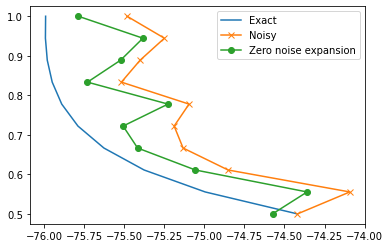

In [7]:
plt.plot(h2o_exact, lengths, label='Exact')

plt.plot(h2o_noisy, lengths, label='Noisy', marker='x')
plt.plot(h2o_zero_n, lengths, label='Zero noise expansion', marker='o')
plt.legend()

In [8]:
np.save('../../week2_data/h2o_zn_expansion.npy', (h2o_exact, h2o_noisy, h2o_zero_n, lengths))

In [9]:
def zn_h4(angle: float):
    xyz_data = get_molecular_data('h4', geometry=angle, xyz_format=True)

    basis = 'sto-3g'
    h4 = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set = basis)
    exact = h4.compute_energy(method='fci')
    hf_reference = hf_occ(2*h4.n_orbitals, h4.n_electrons)
    ham = h4.make_hamiltonian()
    n_ents = ham.n_qubits
    ranked_entangler_groupings = generate_QCC_gradient_groupings(ham.to_openfermion(),
                                                                 2*h4.n_orbitals,
                                                                 hf_reference,
                                                                 cutoff=1.e-6)
    entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*h4.n_orbitals)

    for l in range(1):
        if l == 0:
            qansatz = construct_QMF_ansatz(ham.n_qubits, l)
        else:
            qansatz += construct_QMF_ansatz(ham.n_qubits, l)
        qansatz += construct_QCC_ansatz(entanglers)
    E = tq.ExpectationValue(H=ham, U=qansatz)
    init = {k : np.random.rand() for k in E.extract_variables()}
    noiseless = tq.minimize(objective=E, initial_values=init, method='adam', tol=1.0e-6, print_level=1, maxiter=250)
    converged = noiseless.variables
    noise = tq.circuit.noise.DepolarizingError(0.05, ham.n_qubits)
    mitigation = NoiseMitigation(backend='qiskit', noise_model=noise)
    zero_n, noisy = mitigation.zero_noise_expansion(H=ham, U=qansatz, variables=converged)
    return exact, noiseless.energy, noisy, zero_n

In [10]:
h4_exact, h4_noisy, h4_zero_n = [], [], []
angles = np.linspace(85, 95, 10)
for a in angles:
    exact, _, noisy, zero_n = zn_h4(a)
    h4_exact.append(exact), h4_noisy.append(noisy), h4_zero_n.append(zero_n)

Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 48 expectationvalues
gradient instr  : None
active variables : 24
Iteration: 1 , Energy: +0.22448535, angles: {0beta_0: 0.4204792848114573, 0gamma_0: 0.2345162804072656, 0beta_1: 0.6155827519742165, 0gamma_1: 1.063067464135979, 0beta_2: 1.0239798373953197, 0gamma_2: 0.8385861923919194, 0beta_3: 0.3696908870787118, 0gamma_3: 0.24832633794436584, 0beta_4: 0.8615982536654163, 0gamma_4: 0.5316528307564283, 0beta_5: 0.8079650503563184, 0gamma_5: 1.087931210881383, 0beta_6: 0.3660407377387576, 0gamma_6: -0.08580516528260516, 0beta_7: 0.6407923857512118, 0gamma_7: -0.015273884106334623, 0tau_0: 0.3405023824372232, 0tau_1: 1.0901110058796852, 0tau_2: 1.0877181503014017, 0tau_3: 0.2505303127920903, 0tau_4: 0.3303708308017645, 0tau_5: -0.06743950796206762, 0tau_6: 0.4092757731580954

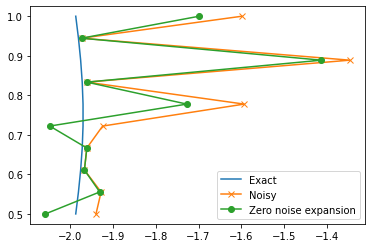

In [11]:
plt.plot(h4_exact, lengths, label='Exact')
plt.plot(h4_noisy, lengths, label='Noisy', marker='x')
plt.plot(h4_zero_n, lengths, label='Zero noise expansion', marker='o')
plt.legend()

In [12]:
np.save('../../week2_data/h4_zn_expansion.npy', (h4_exact, h4_noisy, h4_zero_n, lengths))

In [13]:
def zn_n2(r: float):
    xyz_data = get_molecular_data('n2', geometry=r, xyz_format=True)

    basis = '6-31g'
    active = {'AG': [1, 3], 'B1U': [0, 1], 'B3U': [0]}
    n2 = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set = basis, active_orbitals = active)
    exact = n2.compute_energy(method='fci')
    hf_reference = hf_occ(2*n2.n_orbitals, n2.n_electrons)
    ham = n2.make_hamiltonian()
    n_ents = ham.n_qubits
    ranked_entangler_groupings = generate_QCC_gradient_groupings(ham.to_openfermion(),
                                                                 2*n2.n_orbitals,
                                                                 hf_reference,
                                                                 cutoff=1.e-6)
    entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*n2.n_orbitals)

    for l in range(1):
        if l == 0:
            qansatz = construct_QMF_ansatz(ham.n_qubits, l)
        else:
            qansatz += construct_QMF_ansatz(ham.n_qubits, l)
        qansatz += construct_QCC_ansatz(entanglers)
    E = tq.ExpectationValue(H=ham, U=qansatz)
    init = {k : np.random.rand() for k in E.extract_variables()}
    noiseless = tq.minimize(objective=E, initial_values=init, method='adam', tol=1.0e-6, print_level=1, maxiter=250)
    converged = noiseless.variables
    noise = tq.circuit.noise.DepolarizingError(0.05, ham.n_qubits)
    mitigation = NoiseMitigation(backend='qiskit', noise_model=noise)
    zero_n, noisy = mitigation.zero_noise_expansion(H=ham, U=qansatz, variables=converged)
    return exact, noiseless.energy, noisy, zero_n

In [ ]:
n2_exact, n2_noisy, n2_zero_n = [], [], []
lengths = np.linspace(0.1, 2, 10)
for l in lengths:
    exact, _, noisy, zero_n = zn_n2(l)
    n2_exact.append(exact), n2_noisy.append(noisy), n2_zero_n.append(zero_n)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 60 expectationvalues
gradient instr  : None
active variables : 30
Iteration: 1 , Energy: +87.70058374, angles: {0beta_0: 0.18193951024372115, 0gamma_0: 0.1624306407170787, 0beta_1: 1.0971698554998939, 0gamma_1: 0.14112418378817354, 0beta_2: 1.0826648555440592, 0gamma_2: 0.776178992182319, 0beta_3: 0.29154863372621337, 0gamma_3: 0.4978546344696062, 0beta_4: 0.8726817099607098, 0gamma_4: 0.48417113632999986, 0beta_5: 0.7525180381820016, 0gamma_5: 0.5025142137858699, 0beta_6: 1.083784798018492, 0gamma_6: 0.8214801547930684, 0beta_7: 0.5910137946357821, 0g

In [ ]:
plt.plot(n2_exact, lengths, label='Exact')
plt.plot(n2_noisy, lengths, label='Noisy', marker='x')
plt.plot(n2_zero_n, lengths, label='Zero noise expansion', marker='o')
plt.legend()

In [ ]:
np.save('../../week2_data/n2_zn_expansion.npy', (n2_exact, n2_noisy, n2_zero_n, lengths))